# Пространственная фильтрация

**Автор**: Винник Екатерина Петровна, 22.М04

**Задание**: должна быть реализована:
- линейная фильтрация
   - однородная
   - взвешенное среднее по маскам различных размеров
- нелинейная (медианная)


## Линейная фильтрация (однородная, взвешенное среднее по маскам различных размеров)
### Теория

Идея фильтрации заключается в том, что каждый пиксель изображения обрабатывается в соответствии с его локальным окружением (часто включая самого себя). В этой модели данный пиксель обычно помещается в центр "окна" нечетного размера (также называемого «ядром» или «маской»), затем весь набор пикселей внутри маски обрабатывается в соответствии с некоторой операцией, которая возвращает новое значение для пикселя в центре. Сами операции могут быть линейными или нелинейными. В этом разделе рассматриваются только линейные операции.

1)
Преобразование однородной фильтрации изображения задается следующим образом:
$R= \dfrac{1}{n^2}  \sum_{(i=1)}^{n} z_i $

2)
Коэффициенты маски фильтра вычисляются с помощью гауссовой функции: $h(x,y)=e^{(-(x^2+y^2)/(2σ^2 ))}$, где $σ$ -- стандартное отклонение.
Преобразование взвешенной средней фильтрации изображения задается следующим образом:
$g(x,y)=\dfrac{(\sum_{(s=-a)}^{a}\sum_{(t=-b)}^{b}w(s,t)  f(x+s,y+t))}{(\sum_{(s=-a)}^a\sum_{(t=-b)}^b w(s,t))},  m=2a+1,n=2b+1$

Упомянутые выше типы фильтров используются для сглаживания изображения.

### Реализация

#### Однородная фильтрация

In [1]:
import numpy as np


def uniform_average(img, ker_size=3):
    h = img.shape[0]
    w = img.shape[1]
    pad_size = (ker_size - 1) // 2
    
    img_new = np.zeros_like(img, dtype=float)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        filt = np.full((ker_size, ker_size, channels), 1 / (ker_size * ker_size))
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels))
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size, :]
                for ch in range(channels):
                    img_new[i, j, ch] = np.sum(np.multiply(img_loc[:, :, ch], filt[:, :, ch]))
    else:
        filt = np.full((ker_size, ker_size), 1 / (ker_size * ker_size))
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size]
                img_new[i, j] = np.sum(np.multiply(img_loc, filt))
                
    img_new = img_new.astype(np.uint8)
    return img_new

#### Взвешенная средняя фильтрация

In [2]:
import numpy as np


def apply_w_av(img, filt):
    h = img.shape[0]
    w = img.shape[1]
    ker_size = filt.shape[0]
    pad_size = (ker_size - 1) // 2
    
    img_new = np.zeros_like(img, dtype=float)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        for ch in range(channels):
            filt[:, :, ch] = filt[:, :, ch] / np.sum(filt[:, :, ch])
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels))
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size, :]
                for ch in range(channels):
                    img_new[i, j, ch] = np.sum(np.multiply(img_loc[:, :, ch], filt[:, :, ch]))
    else:
        filt = filt / np.sum(filt)
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size]
                img_new[i, j] = np.sum(np.multiply(img_loc, filt))
                
    img_new = img_new.astype(np.uint8)
    return img_new

#### Гауссова функция

In [3]:
import numpy as np


def get_gaussian_kernel(ker_size=3):
    kernel = np.zeros((ker_size, ker_size))
    a = (ker_size - 1) // 2
    for i in range(ker_size):
        for j in range(ker_size):
            s = i - a
            t = j - a
            kernel[i, j] = np.exp(-(s*s + t*t) / 2.)
            
    kernel = kernel / np.sum(kernel)
            
    return kernel

### Результаты применения линейной фильтрации к изображениям

Загрузим изображения для дальнейшей обработки:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# http://pages.cs.wisc.edu/~lizhang/projects/autoexpo/content/text.html
img_1 = Image.open('./text1.png')
img_2 = Image.open('./images.webp')

In [5]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Размеры изображений:')
print(np_1.shape)
print(np_2.shape)

Размеры изображений:
(450, 450, 3)
(683, 500, 3)


#### Применение линейной фильтрации к первому изображению
##### Применение однородной фильтрации

Применим к первому изображению (изображению с текстом) однородную фильтрацию для разных размеров маски -- 3, 5 и 9 соответственно, чтобы сравнить результаты применения с исходным изображением.

In [6]:
np_1_b3 = uniform_average(np_1, 3)

In [7]:
np_1_b5 = uniform_average(np_1, 5)

In [8]:
np_1_b9 = uniform_average(np_1, 9)

Рассмотрим исходное изображение и изображения, получившиеся в результате применения однородной фильтрации при размерах маски, равных 3, 5, 9.

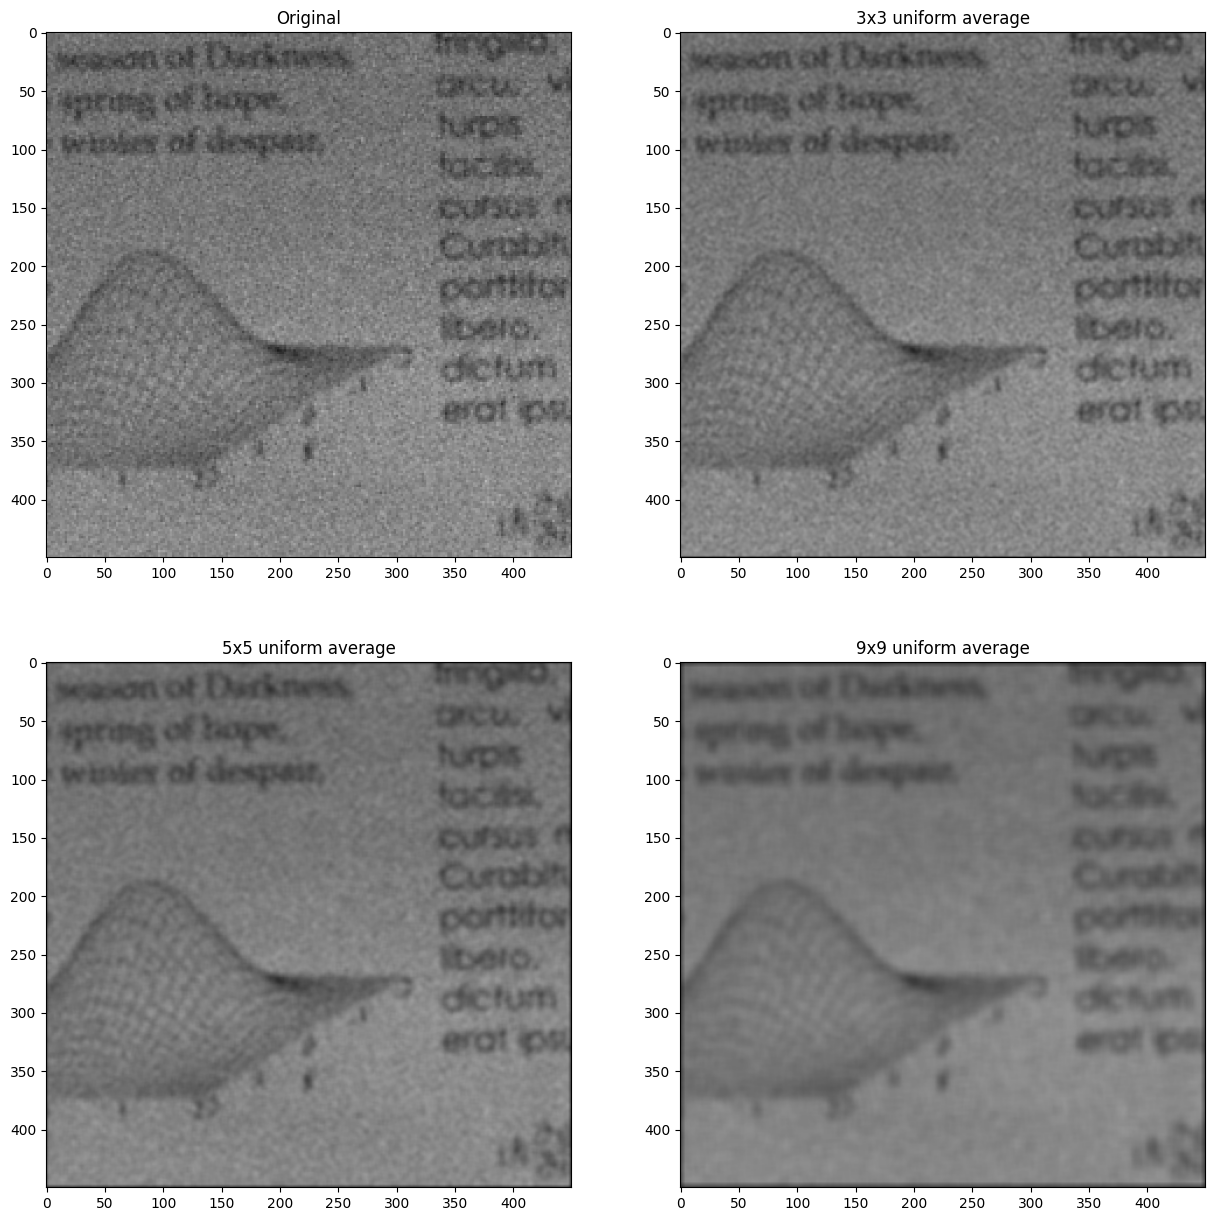

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(np_1)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(np_1_b3)
axs[0, 1].set_title('3x3 uniform average')
axs[1, 0].imshow(np_1_b5)
axs[1, 0].set_title('5x5 uniform average')
axs[1, 1].imshow(np_1_b9)
axs[1, 1].set_title('9x9 uniform average')
plt.show()

Первое изображение обладает мелкозернистым шумом, который делает текст на изображении трудно читаемым. При $n=3$ можно заметить легкую расфокусировку на всем изображении, более всего фильтрация при $n=3$ повлияла на мелкие детали, близкие к размерам фильтра, т.е., на мелкие белые засветы шума на изображении. При $n=5$ шум стал менее выраженным, что позволяет читать текст, изображенный на картинке -- например, становятся видны слова *hope*, *despair*. При $n=9$ можно увидеть значительно более сильную расфокусировку -- буквы текста начинают сливаться, демонстрируя тем самым эффект смешивания, являющийся результатом расфокусировки. Становятся слабо видны мелкие детали. Такое чрезмерное сглаживание используется для удаления с изображения мелких объектов.

Для данного изображения наиболее подошла фильтрация при $n=5$ -- фильтрация при $n=3$ не дала нужного сглаживания, а фильтрация при $n=9$ чрезмерно расфокусировала изображение.

##### Применение взвешенной средней фильтрации к первому изображению
Рассмотрим применение взвешенного среднего фильтра, коэффициенты маски фильтра вычисляются с помощью гауссовой функции:

In [10]:
# get the kernels
norm3 = np.repeat(get_gaussian_kernel(3).reshape((3, 3, 1)), 3, axis=2)
norm9 = np.repeat(get_gaussian_kernel(9).reshape((9, 9, 1)), 3, axis=2)
norm15 = np.repeat(get_gaussian_kernel(15).reshape((15, 15, 1)), 3, axis=2)

Применим взвешенную среднюю фильтрацию к первому изображению.

In [11]:
np_1_w3 = apply_w_av(np_1, norm3)

In [12]:
np_1_w9 = apply_w_av(np_1, norm9)

In [13]:
np_1_w15 = apply_w_av(np_1, norm15)

Сравним исходное изображение и изображения, получившиеся в результате применения взвешенной средней фильтрации при масках размеров $n=3$, $n=5$, $n=9$, $n=15$.

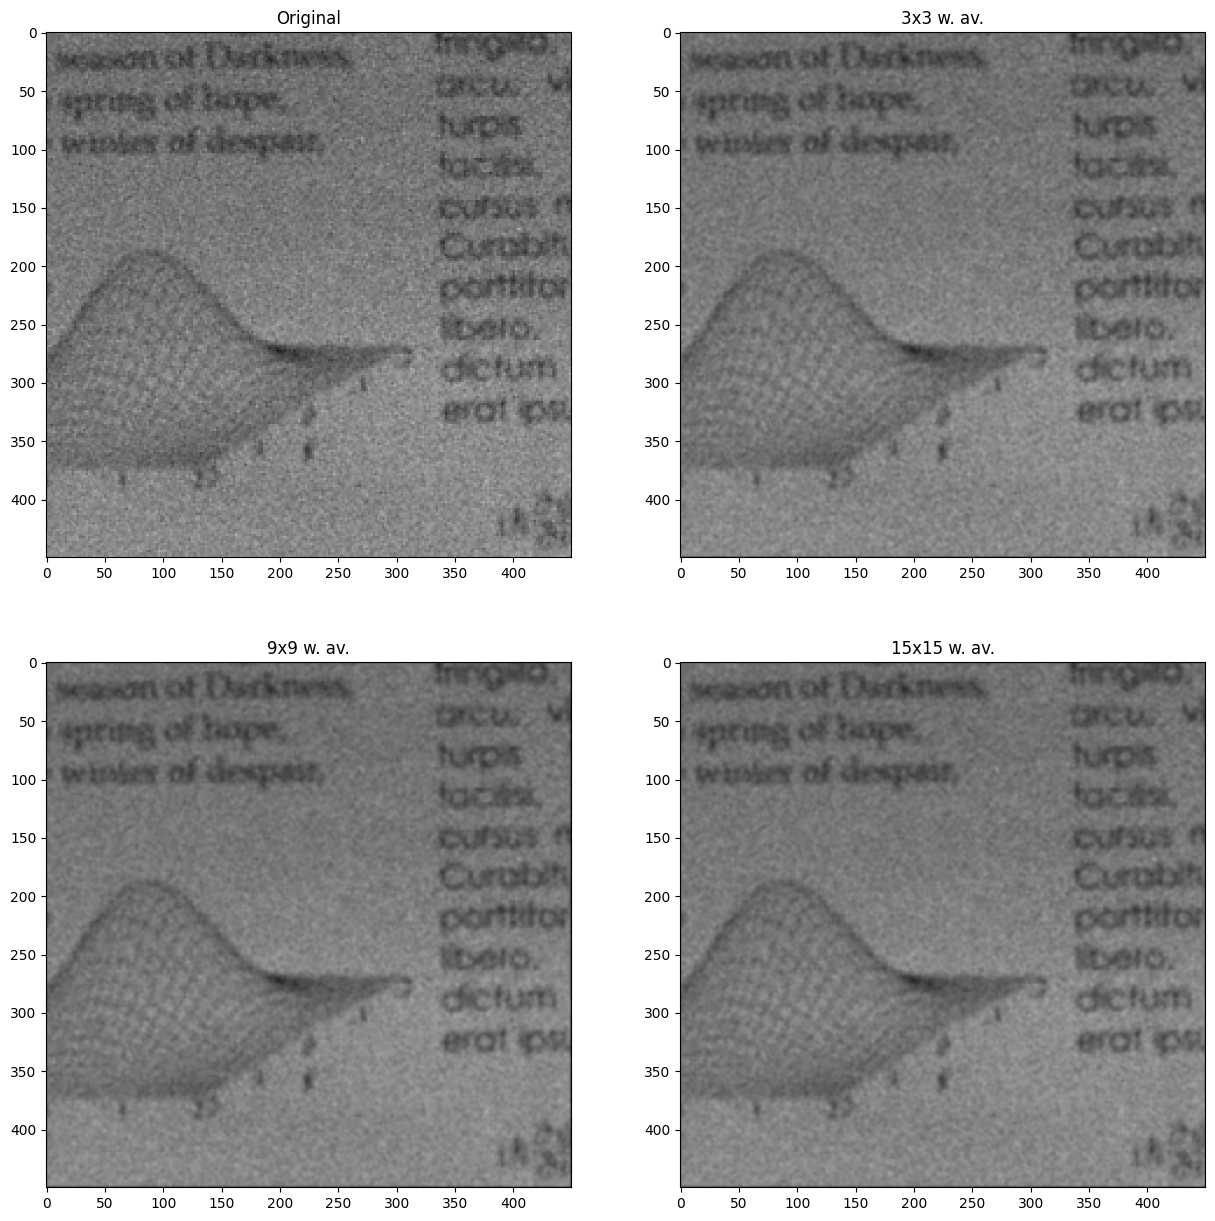

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(np_1)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(np_1_w3)
axs[0, 1].set_title('3x3 w. av.')
axs[1, 0].imshow(np_1_w9)
axs[1, 0].set_title('9x9 w. av.')
axs[1, 1].imshow(np_1_w15)
axs[1, 1].set_title('15x15 w. av.')
plt.show()

Взвешенная средняя фильтрация не производит расфокусировку изображения при увеличении размеров окна так сильно, как это делает однородная фильтрация. Это позволяет читать текст на изображении при $n=15$, что было невозможно при $n=9$ в случае однородной фильтрации. Шумы при взвешенной средней фильтрации также устраняются с увеличением размеров окна. Следует отметить, что на практике достаточно трудно заметить разницу между изображениями, сглаженными фильтрами по одной из масок или какими-то другими, аналогичными по конструкции, поскольку размеры области, покрываемые маской при фильтрации одного элемента, очень малы.


#### Применение однородной линейной фильтрации к дополнительному изображению
Для дополнительной демонстрации сглаживания изображения в результате линейной фильтрации (случай однородной фильтрации) было взято еще одно изображение.

In [15]:
np_2_b3 = uniform_average(np_2, 3)
np_2_b5 = uniform_average(np_2, 5)
np_2_b9 = uniform_average(np_2, 9)

Сравним исходное изображение и изображения, полученные в результате применения однородной фильтрации при размерах окна $n=3$, $n=5$, $n=9$.

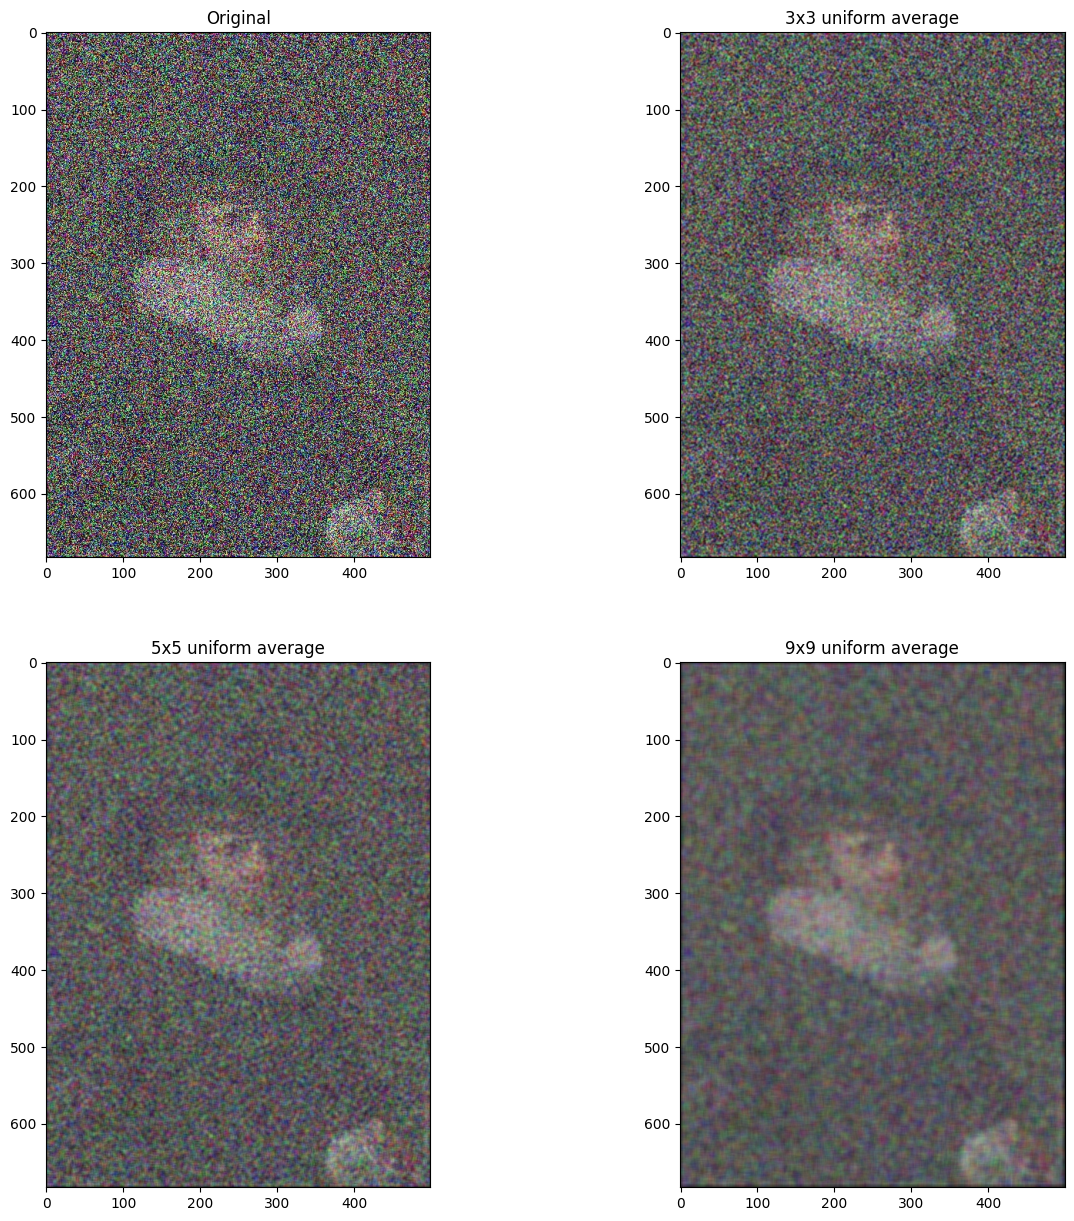

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(np_2)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(np_2_b3)
axs[0, 1].set_title('3x3 uniform average')
axs[1, 0].imshow(np_2_b5)
axs[1, 0].set_title('5x5 uniform average')
axs[1, 1].imshow(np_2_b9)
axs[1, 1].set_title('9x9 uniform average')
plt.show()

В данном примере расфокусировка изображения позволяет создать грубый образ человека, который является главным объектом на этом изображении. При этом яркость мелких объектов -- шума -- смешивается с фоном, в то время как большие объекты -- воротник, черты лица, одежда и головной убор, остаются в виде пятен и могут быть легко обнаружены. Размеры объектов, которые будут смешиваться с фоном, приблизительно совпадают с размерами маски сглаживающего фильтра. 

## Нелинейная фильтрация
### Теория
Медианный фильтр заменяет значение пикселя на значение медианы распределения яркостей всех пикселей в окрестности (включая и исходный). Медианные фильтры весьма популярны потому, что для определенных типов случайных шумов они демонстрируют отличные возможности подавления шума при значительно меньшем эффекте расфокусировки, чем у линейных сглаживающих фильтров с аналогичными размерами. В частности, медианные фильтры эффективны при фильтрации импульсных шумов, иногда называемых шумами «соль и перец», которые выглядят как наложение на изображение случайных черных и белых точек.


### Реализация

#### Медианный фильтр

In [17]:
import numpy as np


def apply_median(img, ker_size=3):
    h = img.shape[0]
    w = img.shape[1]
    pad_size = (ker_size - 1) // 2
    
    img_new = np.zeros_like(img, dtype=float)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels))
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size, :]
                for ch in range(channels):
                    img_new[i, j, ch] = np.median(img_loc[:, :, ch])
    else:
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
        for i in range(h):
            for j in range(w):
                img_loc = img_padded[i:i+ker_size, j:j+ker_size]
                img_new[i, j] = np.median(img_loc[:, :])
                
    img_new = img_new.astype(np.uint8)
    return img_new

### Результаты применения нелинейной фильтрации (медианного фильтра) к изображениям

Загрузим изображение монтажной платы.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# From R. Gonzales, R. Woods "Digital Image Processing"
img_21 = Image.open('./sch.tif')

In [19]:
# represent the images as tensors
np_21 = np.array(img_21)
print('Picture dimensions:')
print(np_21.shape)

Picture dimensions:
(440, 455)


Применим медианный фильтр к изображению.

In [20]:
np_21_m3 = apply_median(np_21, 3)

In [21]:
np_21_m5 = apply_median(np_21, 5)

In [22]:
np_21_m9 = apply_median(np_21, 9)

Рассмотрим исходное изображение, а также изображения, получившиеся в результате применения медианного фильтра с масками размеров $n=3$, $n=5$, $n=9$.

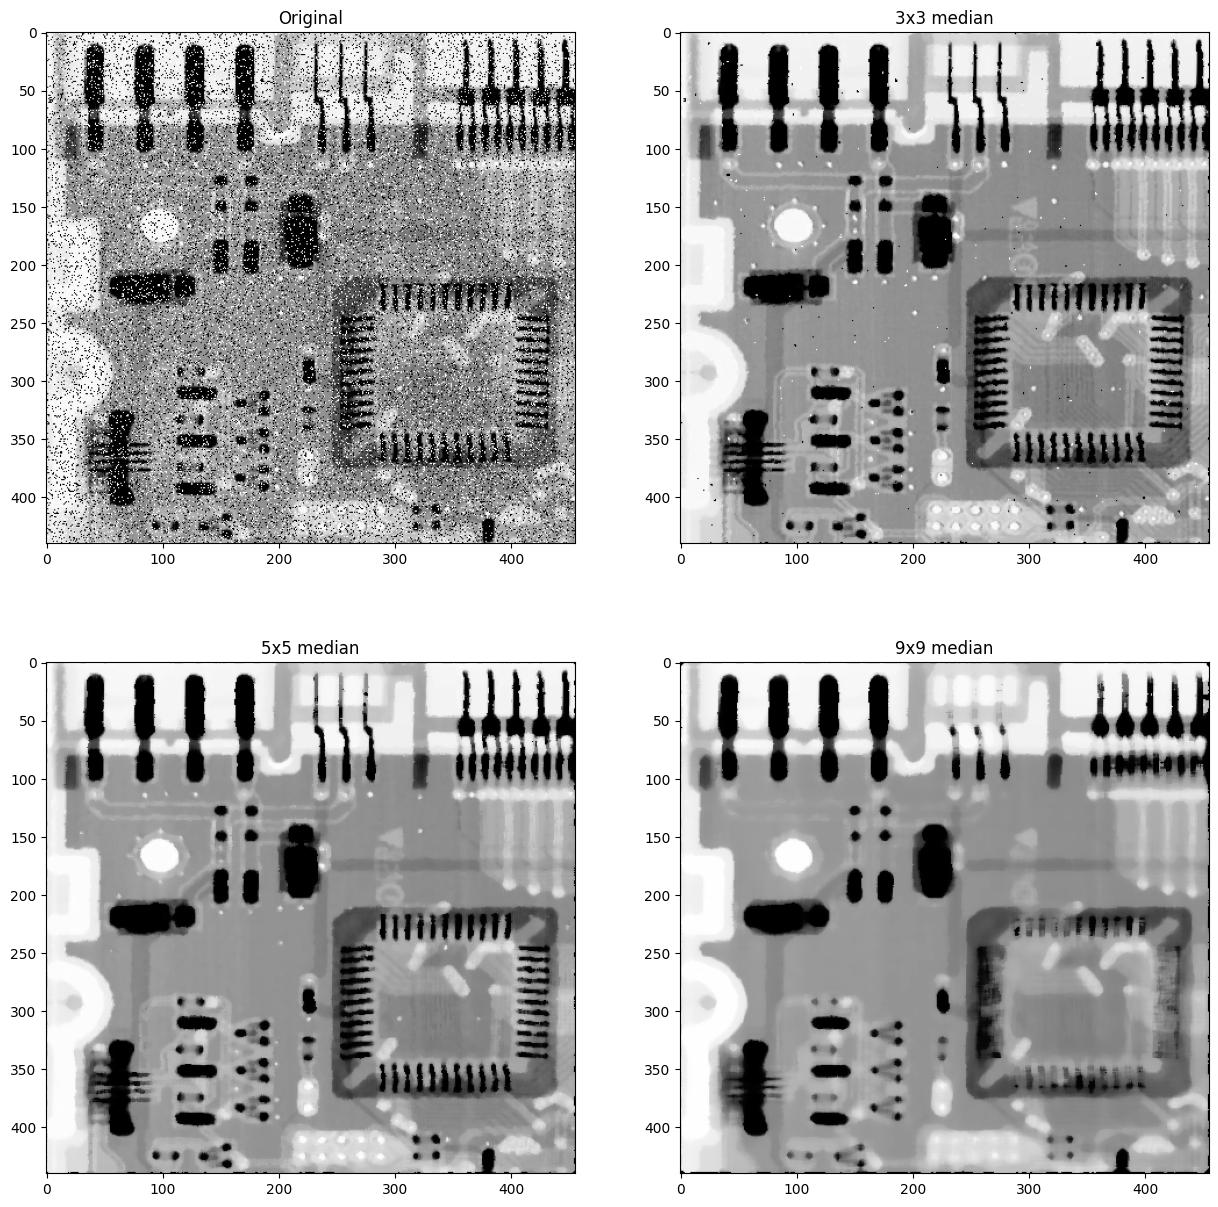

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].imshow(np_21, cmap='gray')
axs[0, 0].set_title('Original')
axs[0, 1].imshow(np_21_m3, cmap='gray')
axs[0, 1].set_title('3x3 median')
axs[1, 0].imshow(np_21_m5, cmap='gray')
axs[1, 0].set_title('5x5 median')
axs[1, 1].imshow(np_21_m9, cmap='gray')
axs[1, 1].set_title('9x9 median')
plt.show()

На исходном изображении представлен рентгеновский снимок монтажной платы, сильно искаженный импульсным шумом. При применении медианного фильтра отличающиеся от фона значения яркостей пикселей заменяются на значения более близкие к его соседям. Медианный фильтр очень хорошо убирает шум, при этом не искажая крупные элементы изображения. Так, в результате применения медианного фильтра с маской размера $n=9$ к изображению монтажной платы шум полностью исчез, и стали хорошо видны крупные элементы платы, например, символы разметки, которых ранее не было видно из-за импульсного шума.